In [1]:
from fastai.vision.all import *
#hide
from fastbook import *

In [2]:
path = Path("../data/usq/train/images")

In [73]:
#fnames = get_image_files(path/"images")
fnames = get_image_files(path)

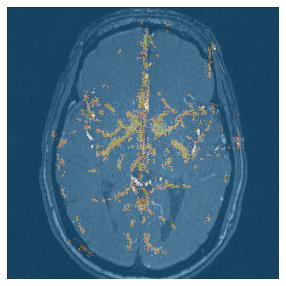

In [74]:
img = PILImage.create(fnames[0])
mask = PILMask.create(str(fnames[0]).replace('images','masks'))
#mask = PILMask.create(str(fnames[0]).replace('mipimages','mipmasks'))
ax = img.show()
ax = mask.show(ctx=ax)

### Load Data

In [5]:
from fastai.vision.all import *
#hide
from fastbook import *

In [6]:
path = Path("../data/usq/train/images")

In [7]:
def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [8]:
codes = ['Background', 'CV']

In [9]:
def get_y(o):
    return get_msk(o)

In [10]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   #item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [7]:
dsets = dblock.datasets(path)

In [11]:
dls = dblock.dataloaders(path, bs=4)
dls.vocab = codes

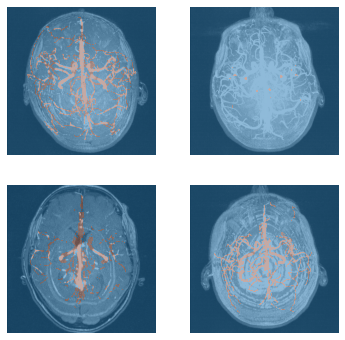

In [71]:
dls.show_batch()

## Modelling

### Vanilla U-Net

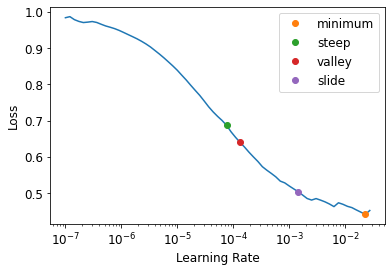

In [78]:
#original unet
learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, Dice()])
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [77]:
# no augment
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.112787,0.121068,0.829907,0.699930,01:30
1,0.080616,0.072340,0.821052,0.787627,01:30
2,0.060764,0.058822,0.878111,0.830200,01:30
3,0.052749,0.050943,0.938129,0.859890,01:30
4,0.048665,0.049400,0.922208,0.861375,01:30


In [79]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 2.29e-03, steepest point: 7.59e-05


In [82]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.112304,0.114369,0.595532,0.658665,01:36
1,0.076699,0.073984,0.723102,0.761747,01:36
2,0.058011,0.058706,0.957737,0.847706,01:35
3,0.048814,0.048532,0.938533,0.865885,01:35
4,0.045841,0.046631,0.935698,0.869591,01:32


In [83]:
learn.unfreeze()

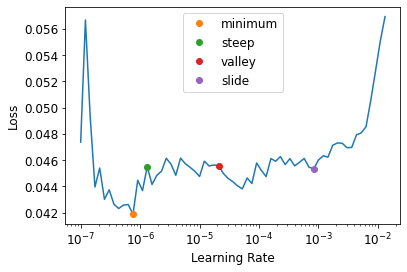

In [84]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [85]:
learn.fit_one_cycle(5, lr_max=lrs.valley)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.048253,0.046628,0.928563,0.868730,01:40
1,0.044506,0.046496,0.941908,0.870915,01:41
2,0.045125,0.046342,0.938603,0.870715,01:41
3,0.046385,0.046291,0.937474,0.870696,01:40
4,0.042966,0.046271,0.937055,0.870698,01:40


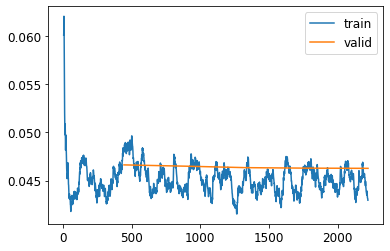

In [86]:
learn.recorder.plot_loss()

### Dense U-Net

In [12]:
import sys
sys.path.append('/home/msadmin/notebooks/msc8001/src')
from dense_unet import *
from fastai import *

2021-10-04 22:23:58,413 util_log.py[147] INFO Start the program at:msdsvm, 10.0.0.4, with:Load module


Adjust wk folder for notebook failed


In [13]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
# unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
#                     self_attention=False, y_range=None, norm_type=NormType,
#                     last_cross=True,
#                     bottle=False)
unet = DynamicUnet(encoder, n_classes=2, img_size=(320, 320), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
#print(unet(torch.rand(1,3,224,224)).shape)

    sn        layer     c    w    h               size
2    2         ReLU    64  160  160  (1, 64, 160, 160)
4    4  _DenseBlock   256   80   80   (1, 256, 80, 80)
6    6  _DenseBlock   512   40   40   (1, 512, 40, 40)
8    8  _DenseBlock  1024   20   20  (1, 1024, 20, 20)
11  11  BatchNorm2d  1024   10   10  (1, 1024, 10, 10)


In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [63]:
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,foreground_acc,time
0,0.038740,0.044601,0.928793,07:55


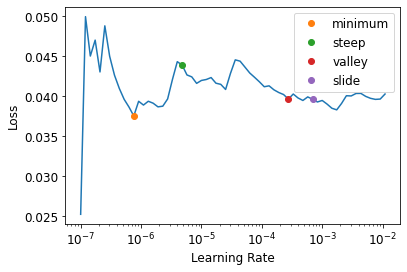

In [65]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [66]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 7.59e-08, steepest point: 4.79e-06


In [64]:
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc])
learn.fit_one_cycle(12, lr_max=slice(lrs.minimum, lrs.steep))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.035723,0.044585,0.928800,07:54
1,0.038172,0.044636,0.928451,07:54
2,0.040596,0.044770,0.927874,07:56
3,0.037489,0.044831,0.927340,07:56
4,0.036460,0.044958,0.926644,07:55
5,0.038200,0.045078,0.926094,07:54
6,0.038247,0.045143,0.925723,07:55
7,0.035932,0.045116,0.925863,07:53
8,0.039358,0.045155,0.925620,07:54
9,0.036066,0.045231,0.925234,07:54


### Weighted Cross Entropy Loss Function

In [34]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [87]:
weights = torch.tensor([[0.5] + [1.5]]).cuda()
weights

tensor([[0.5000, 1.5000]], device='cuda:0')

In [88]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [89]:
# use customer weighted loss function
learn = Learner(dls, unet, loss_func=loss_func, metrics=[foreground_acc, Dice()])
learn.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 160 x 160  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 128 x 80 x 80   
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 32 x 80 x 80    
Conv2d                                    36864    

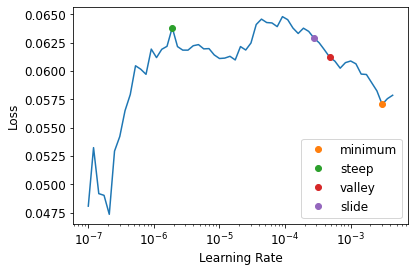

In [90]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [92]:
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.062693,0.063633,0.990589,0.861365,08:41
1,0.057441,0.085919,0.957480,0.856171,07:55
2,0.053625,0.056779,0.990281,0.869778,07:54


In [94]:
learn.unfreeze()

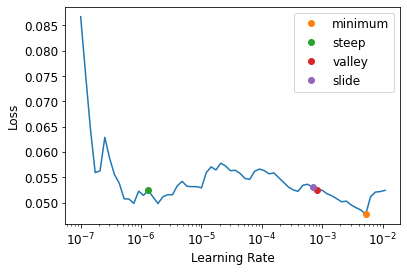

In [95]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [96]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 5.25e-04, steepest point: 1.32e-06


In [ ]:
learn.fit_one_cycle(12, lr_max=slice(8e-3, 1e-2))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.071223,0.070294,0.977222,0.851256,07:56
1,516.812561,0.495445,0.000000,0.000000,07:56


In [52]:
learn.fit_one_cycle(21, lr_max=slice(1e-6,3.981071586167673e-06))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.037874,0.070623,0.945190,0.869055,07:56
1,0.037984,0.070666,0.943897,0.868797,07:54
2,0.037011,0.071059,0.941889,0.868439,07:55
3,0.038431,0.071733,0.939917,0.868029,07:54
4,0.037087,0.071323,0.940441,0.868079,07:55
5,0.037160,0.072033,0.940344,0.867942,07:54
6,0.035752,0.072776,0.940029,0.867858,07:54
7,0.037448,0.072814,0.940238,0.867861,07:55
8,0.037692,0.073264,0.939324,0.867652,07:55
9,0.036474,0.073398,0.939518,0.867601,07:56


In [67]:
# try dice as loss function
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, Dice()])
learn.fit_one_cycle(1)#
#learn.fit_one_cycle(24, lr_max=slice(1e-6,0.00013))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.038852,0.045080,0.937322,0.875536,07:54


In [70]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.042641,0.044699,0.971363,0.874183,07:53


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.041157,0.044283,0.942753,0.877284,07:55
1,0.039899,0.044166,0.919540,0.873597,07:54
2,0.036897,0.045219,0.924232,0.874406,07:55


In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [17]:
learn.fit_one_cycle(48, lr_max=slice(1e-6,0.00013))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.118556,0.114985,0.615694,0.655080,07:55
1,0.112288,0.110943,0.616278,0.661270,07:55
2,0.106062,0.103195,0.625149,0.676979,07:56
3,0.095836,0.092407,0.645908,0.702038,07:56
4,0.081122,0.081511,0.838801,0.774944,07:56
5,0.070743,0.069843,0.751617,0.776966,07:56
6,0.064638,0.063234,0.866156,0.820113,07:55
7,0.061951,0.058609,0.866312,0.833344,07:57
8,0.059048,0.055486,0.899142,0.845620,07:57
9,0.054147,0.054517,0.924820,0.850305,07:56


## Results

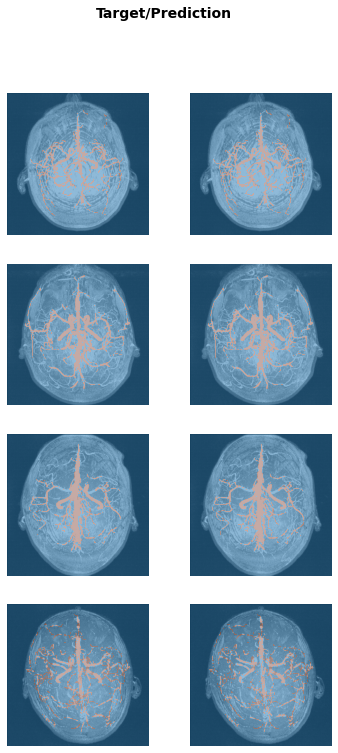

In [19]:
learn.show_results()

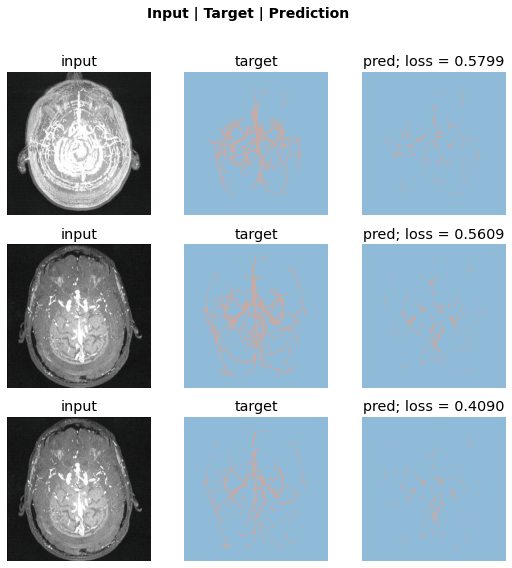

In [20]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

### Save model

In [72]:
learn.export('dense_unet_model.pkl')

In [15]:
## Measure

In [25]:
def calc_metrics (gt, pred, heading, short=True): 
    diff = gt - (pred *2)
    fn = (diff== 1).sum()
    tp = (diff==-1).sum()
    fp = (diff==-2).sum()
    tn = (diff== 0).sum()
    p  = tp / (tp + fp)  # precision 
    r  = tp / (tp + fn)  # recall 
    f1 = 2*p*r/(p+r)     # F1 score
    print(heading)
    if not short: 
        print('FN - Green  - (Blood vessel missed):                  ' + str(fn) )
        print('TP - Yellow - (Correctly classified as blood vessel): ' + str(tp) )
        print('FP - Red    - (Wrongly classified as blood vessel):   ' + str(fp) )
        print('TN - Opaque - (Correctly classified as background):   ' + str(tn) )
        print('***************************************************************')
        print('Total pixel number:                                   ' + str(fn+tp+fp+tn))
        print('    ')
    print('Precision:   ' + str(np.round(100*p,2))+'%')
    print('Recall:      ' + str(np.round(100*r,2))+'%')
    print('F1 Score:    ' + str(np.round(100*2*p*r/(p+r),2))+'%')
    print('    ')

In [ ]:
calc_metrics(gt_trn,pred_trn,'Overall Performance across all training data')

In [91]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1